In [ ]:
!pip install tslearn
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.5 MB/s eta 0:00:00


   0     1     2     3     4     5     6     7      8      9     ...  4088  \
0   0.0 -73.0 -66.0 -59.0 -58.0 -53.0 -73.0 -94.0 -116.0 -129.0  ... -94.0   
1   0.0 -31.0 -43.0 -39.0 -39.0  -9.0  -5.0  18.0    7.0  -12.0  ... -32.0   
2   0.0 -41.0 -38.0 -31.0 -25.0 -32.0 -27.0 -29.0  -20.0    1.0  ...  25.0   
3   0.0  14.0  25.0  31.0  36.0  33.0  33.0  27.0   27.0   21.0  ...  -6.0   
4   0.0  14.0  26.0  32.0  25.0  16.0   8.0   8.0   12.0   11.0  ...   1.0   

    4089   4090   4091   4092   4093   4094   4095   4096  4097  
0 -103.0 -111.0 -120.0 -121.0 -120.0 -124.0 -113.0 -109.0 -93.0  
1  -32.0  -40.0  -23.0   -1.0   11.0   12.0   -6.0   10.0  33.0  
2   40.0   60.0   66.0   58.0   38.0   22.0    1.0  -13.0  -1.0  
3   -7.0   -2.0  -20.0  -34.0  -40.0  -40.0  -26.0  -28.0  21.0  
4  -19.0  -29.0  -35.0  -51.0  -55.0  -58.0  -32.0   -6.0 -17.0  

[5 rows x 4098 columns]
[[[ -73.]
  [ -66.]
  [ -59.]
  ...
  [-113.]
  [-109.]
  [ -93.]]

 [[ -31.]
  [ -43.]
  [ -39.]
  ...
  [  -

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Silhouette Score: 0.7026193528455689
Davies-Bouldin Score: 0.6562764666617584
Calinski-Harabasz Score: 112.70171839705147


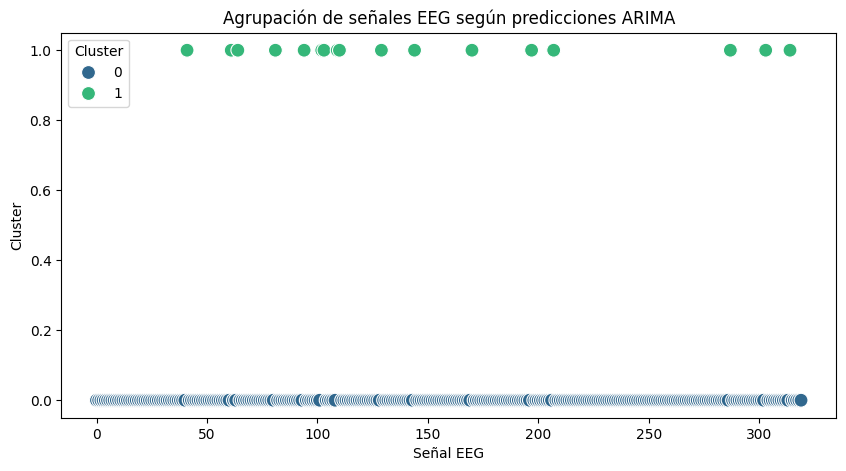

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


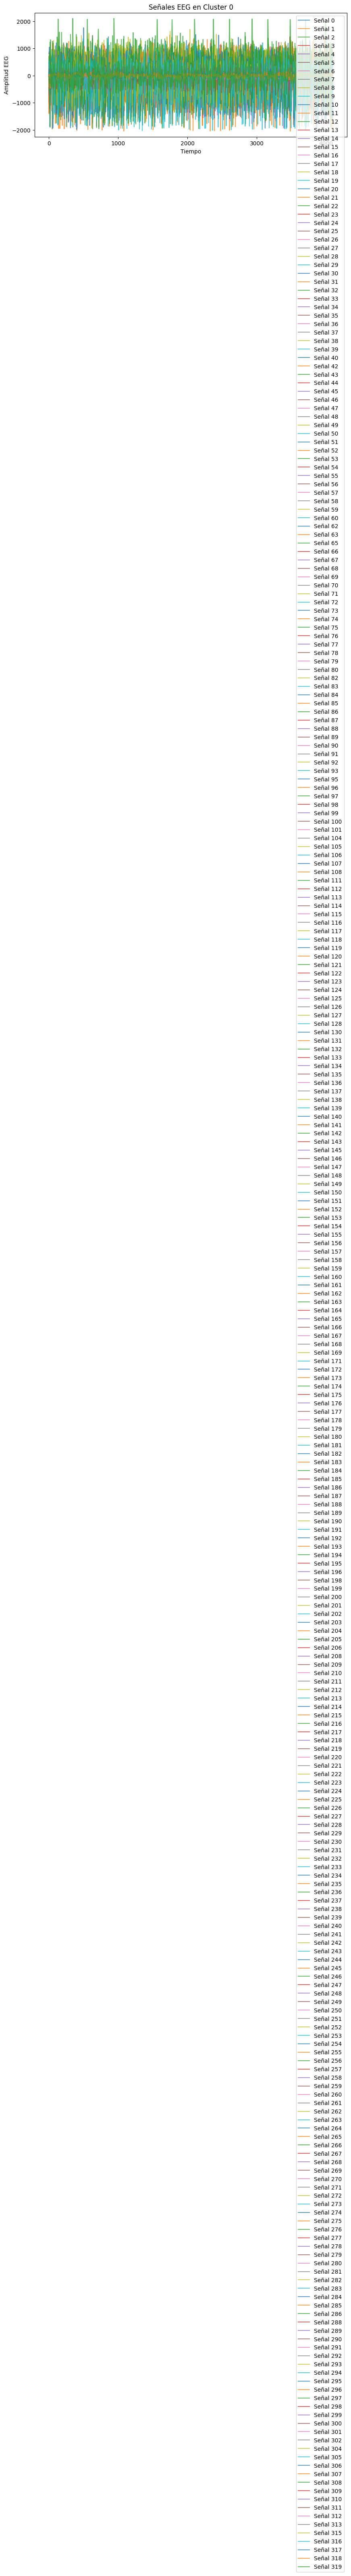

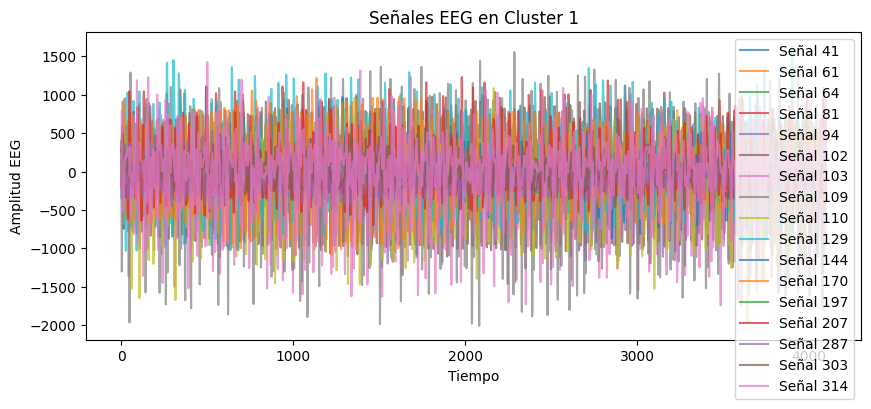

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.cluster import KMeans
from tslearn.utils import to_time_series_dataset
from sklearn.model_selection import train_test_split
from scipy.signal import butter, filtfilt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# 📌 Cargar los datos EEG desde el archivo CSV
data = np.loadtxt("/content/bonn_dataset_columns.csv", delimiter=",")[:, :].T
dataDF = pd.DataFrame(data)
print(dataDF.head())
X = to_time_series_dataset(data[:, 1:])
print(X)
y = data[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.squeeze(-1)  # Elimina la última dimensión
X_test = X_test.squeeze(-1)

# 📌 Definir el filtro pasa-bajas
def low_pass_filter(signal, cutoff=40.0, fs=256.0, order=5):
    nyquist = 0.5 * fs  # Frecuencia de Nyquist
    normal_cutoff = cutoff / nyquist  # Normalización de la frecuencia de corte
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)  # Aplicar filtro

# Parámetros del filtro
cutoff_freq = 40.0  # Frecuencia de corte de 40 Hz
fs = 173.61  # Frecuencia de muestreo

# 📌 Filtrar señales EEG
X_train_filtered = np.array([low_pass_filter(signal, cutoff=cutoff_freq, fs=fs) for signal in X_train])
X_test_filtered = np.array([low_pass_filter(signal, cutoff=cutoff_freq, fs=fs) for signal in X_test])

print("Número de series temporales en el conjunto de entrenamiento:", X_train_filtered.shape[0])
print("Número de series temporales en el conjunto de prueba:", X_test_filtered.shape[0])
print("Longitud de las series temporales:", X_train_filtered.shape[1])

# 📌 Determinar p y q usando ACF y PACF
def determine_arima_order(signal):
    p = int(input("Elige un valor para p basado en PACF: "))
    q = int(input("Elige un valor para q basado en ACF: "))

    return p, q

# 📌 Aplicar ARIMA a cada señal EEG
order_list = []
n_forecast = 40  # Número de valores a predecir
predictions = []
p, q = determine_arima_order(X_train_filtered[0])
d = 0  # Diferenciación por defecto
order = (p, d, q)

for signal in X_train_filtered:
    order_list.append(order)

    model = ARIMA(signal, order=order)
    fitted_model = model.fit()
    forecast = fitted_model.forecast(steps=n_forecast)
    predictions.append(forecast)

# 📌 Convertir predicciones en array NumPy
predictions_array = np.array(predictions)

# 📌 Aplicar K-Means para agrupar señales similares
num_clusters = 2  # Número de clusters deseados
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(predictions_array)

# 📌 Evaluar el clustering
silhouette_avg = silhouette_score(predictions_array, clusters)
davies_bouldin = davies_bouldin_score(predictions_array, clusters)
calinski_harabasz = calinski_harabasz_score(predictions_array, clusters)

print(f"Silhouette Score: {silhouette_avg}")
print(f"Davies-Bouldin Score: {davies_bouldin}")
print(f"Calinski-Harabasz Score: {calinski_harabasz}")

# 📌 Crear un DataFrame con los clusters asignados
df_clusters = pd.DataFrame({
    "Señal": np.arange(len(X_train_filtered)),
    "Cluster": clusters
})

# 📊 Visualizar los clusters con un gráfico de dispersión
plt.figure(figsize=(10, 5))
sns.scatterplot(x=df_clusters["Señal"], y=df_clusters["Cluster"], hue=df_clusters["Cluster"], palette="viridis", s=100)
plt.xlabel("Señal EEG")
plt.ylabel("Cluster")
plt.title("Agrupación de señales EEG según predicciones ARIMA")
plt.legend(title="Cluster")
plt.show()

# 📊 Mostrar las señales agrupadas por cluster
for c in range(num_clusters):
    plt.figure(figsize=(10, 4))
    for i in range(len(X_train_filtered)):
        if clusters[i] == c:
            plt.plot(X_train_filtered[i], alpha=0.7, label=f"Señal {i}")

    plt.title(f"Señales EEG en Cluster {c}")
    plt.xlabel("Tiempo")
    plt.ylabel("Amplitud EEG")
    plt.legend()
    plt.show()


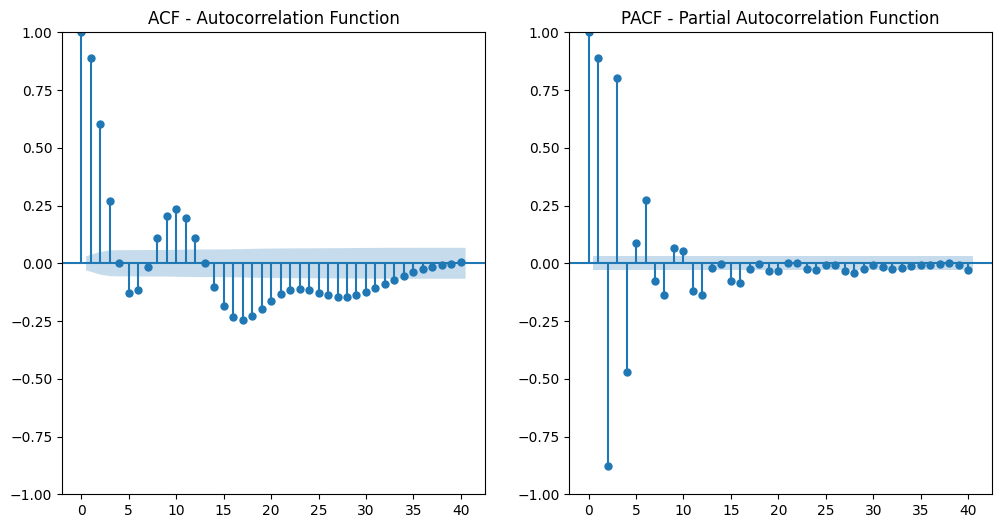

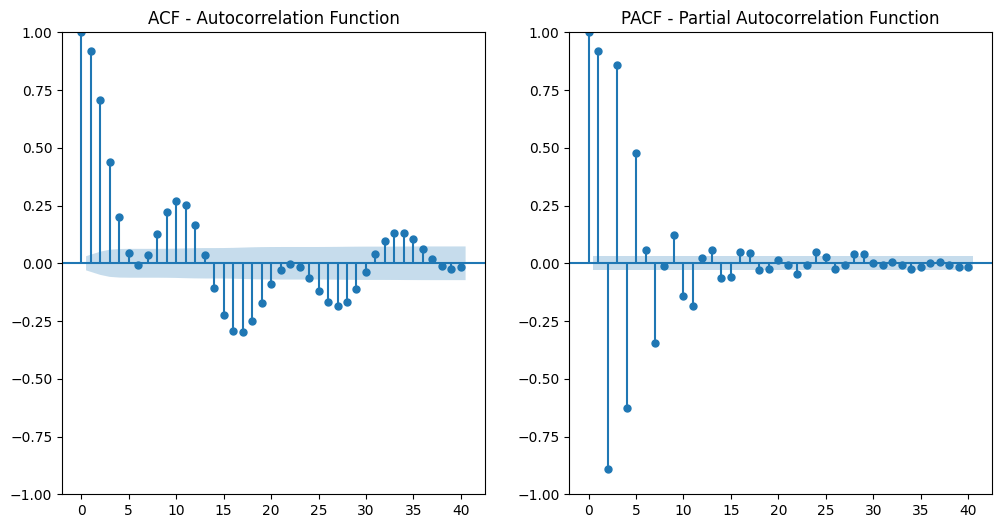

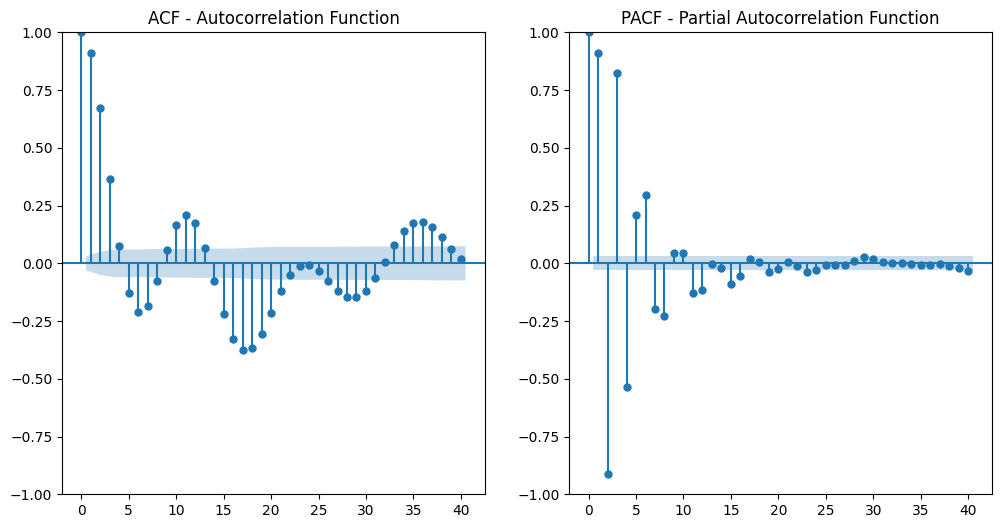

In [ ]:
# 📌 Determinar p y q usando ACF y PACF
def determine_arima_order(signal):
    plt.figure(figsize=(12, 6))

    plt.subplot(121)
    plot_acf(signal, lags=40, ax=plt.gca())
    plt.title("ACF - Autocorrelation Function")

    plt.subplot(122)
    plot_pacf(signal, lags=40, ax=plt.gca())
    plt.title("PACF - Partial Autocorrelation Function")

    plt.show()

    return


determine_arima_order(X_train_filtered[0])
determine_arima_order(X_train_filtered[160])
determine_arima_order(X_train_filtered[300])



📌 Aplicando K-Means con 2 clusters...
Silhouette Score: 0.7908397916269532
Davies-Bouldin Score: 0.5074779342138392
Calinski-Harabasz Score: 220.4598512720371


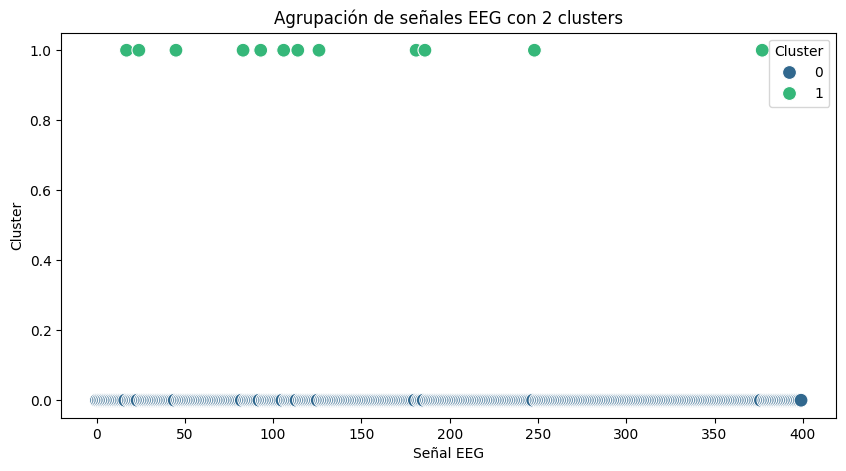


📌 Aplicando K-Means con 3 clusters...
Silhouette Score: 0.7548231859922063
Davies-Bouldin Score: 0.5098864868188847
Calinski-Harabasz Score: 401.6190911342006


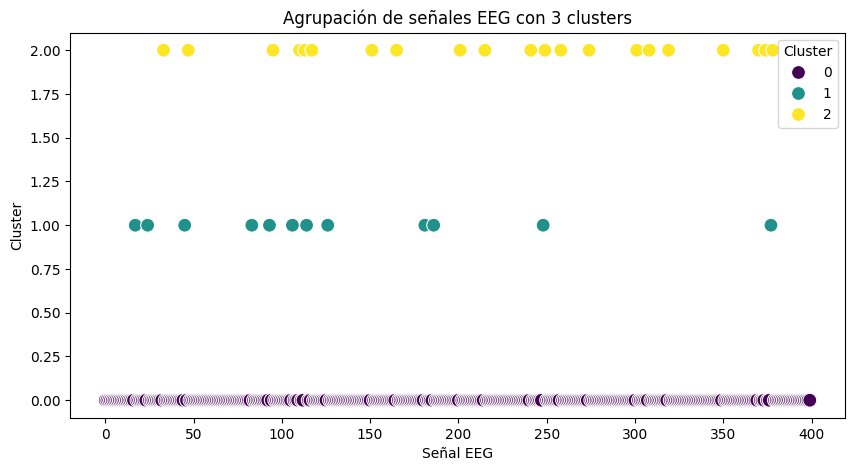


📌 Aplicando K-Means con 5 clusters...
Silhouette Score: 0.5528609724029129
Davies-Bouldin Score: 0.6209216214753798
Calinski-Harabasz Score: 492.43522257425576


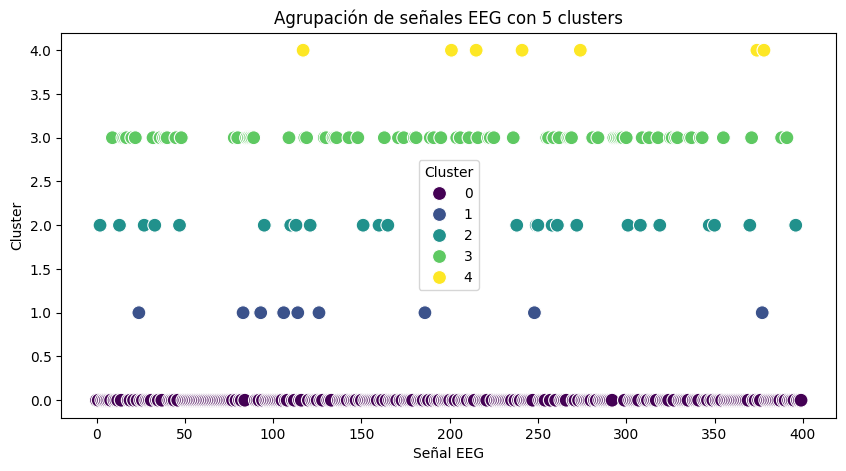

In [ ]:
# 📌 Evaluar clustering para diferentes números de clusters
num_clusters_list = 2  # Probar con 2, 3 y 5 clusters
tol_value = 1e-4  # Tolerancia
max_iter = 300  # Iteraciones máximas

for num_clusters in num_clusters_list:
    print(f"\n📌 Aplicando K-Means con {num_clusters} clusters...")

    # 📌 Aplicar K-Means
    kmeans = KMeans(n_clusters=num_clusters, tol=tol_value, max_iter=max_iter, random_state=42)
    clusters = kmeans.fit_predict(predictions_array)

    # 📌 Evaluar el clustering
    silhouette_avg = silhouette_score(predictions_array, clusters)
    davies_bouldin = davies_bouldin_score(predictions_array, clusters)
    calinski_harabasz = calinski_harabasz_score(predictions_array, clusters)

    print(f"Silhouette Score: {silhouette_avg}")
    print(f"Davies-Bouldin Score: {davies_bouldin}")
    print(f"Calinski-Harabasz Score: {calinski_harabasz}")

    # 📌 Crear un DataFrame con los clusters asignados
    df_clusters = pd.DataFrame({
        "Señal": np.arange(len(X_train_filtered)),
        "Cluster": clusters
    })

    # 📊 Visualizar los clusters con un gráfico de dispersión
    plt.figure(figsize=(10, 5))
    sns.scatterplot(x=df_clusters["Señal"], y=df_clusters["Cluster"], hue=df_clusters["Cluster"], palette="viridis", s=100)
    plt.xlabel("Señal EEG")
    plt.ylabel("Cluster")
    plt.title(f"Agrupación de señales EEG con {num_clusters} clusters")
    plt.legend(title="Cluster")
    plt.show()


In [ ]:
# 📌 Evaluar clustering para diferentes combinaciones de clusters, tol y max_iter
num_clusters_list = [2, 3, 5]  # Probar con 2, 3 y 5 clusters
tol_values = [1e-3, 1e-5, 1e-6]  # Diferentes valores de tolerancia
max_iter_values = [200, 300, 500]  # Diferentes números de iteraciones máximas

# Iterar sobre todas las combinaciones de parámetros
for num_clusters in num_clusters_list:
    for tol_value in tol_values:
        for max_iter_value in max_iter_values:
            print(f"\n📌 Aplicando K-Means con {num_clusters} clusters, tol={tol_value}, max_iter={max_iter_value}...")

            # 📌 Aplicar K-Means con los valores específicos de esta iteración
            kmeans = KMeans(n_clusters=num_clusters, tol=tol_value, max_iter=max_iter_value, random_state=42)
            clusters = kmeans.fit_predict(predictions_array)

            # 📌 Evaluar el clustering
            silhouette_avg = silhouette_score(predictions_array, clusters)
            davies_bouldin = davies_bouldin_score(predictions_array, clusters)
            calinski_harabasz = calinski_harabasz_score(predictions_array, clusters)

            print(f"Silhouette Score: {silhouette_avg}")
            print(f"Davies-Bouldin Score: {davies_bouldin}")
            print(f"Calinski-Harabasz Score: {calinski_harabasz}")

            # 📌 Crear un DataFrame con los clusters asignados
            df_clusters = pd.DataFrame({
                "Señal": np.arange(len(X_train_filtered)),
                "Cluster": clusters
            })


📌 Aplicando K-Means con 2 clusters, tol=0.001, max_iter=200...
Silhouette Score: 0.7908397916269532
Davies-Bouldin Score: 0.5074779342138392
Calinski-Harabasz Score: 220.4598512720371

📌 Aplicando K-Means con 2 clusters, tol=0.001, max_iter=300...
Silhouette Score: 0.7908397916269532
Davies-Bouldin Score: 0.5074779342138392
Calinski-Harabasz Score: 220.4598512720371

📌 Aplicando K-Means con 2 clusters, tol=0.001, max_iter=500...
Silhouette Score: 0.7908397916269532
Davies-Bouldin Score: 0.5074779342138392
Calinski-Harabasz Score: 220.4598512720371

📌 Aplicando K-Means con 2 clusters, tol=1e-05, max_iter=200...
Silhouette Score: 0.7908397916269532
Davies-Bouldin Score: 0.5074779342138392
Calinski-Harabasz Score: 220.4598512720371

📌 Aplicando K-Means con 2 clusters, tol=1e-05, max_iter=300...
Silhouette Score: 0.7908397916269532
Davies-Bouldin Score: 0.5074779342138392
Calinski-Harabasz Score: 220.4598512720371

📌 Aplicando K-Means con 2 clusters, tol=1e-05, max_iter=500...
Silhouette 

1er flujo
notebook que trabajo dos clusters con kshape sobre la señal pura (unir base de datos para solo dos clases)

split 70-30 en base chb. el entrenamiento pasa al kshape y con metricas supervisadas se califica la calidad de clusterizacion. Verificar parametros kshape, probar puntos en las vecindades de los valores por default. Gricsearch de vecindad

Posiblement, montar un cross validation. para que arroja un vector de resultados.





2do flujo
usando los mimos datops, con la misma division y normalizacion (standardscaler y minmax scaler). Viene aplicacion metodo arima sobre el conjunto de entrenamineto, arroja un dataset calcuoado con caracteristicas (ver que es lo que devuelvea arima).
Sobre este espacio de caracteristicas se hace clusterizacion con kmeans. calcular las mimsas metricas del primer flujo. Verificar que espacio genera arima, cuantas caracteristicas arroja, como se transforma la señal.